In [1]:
import numpy as np
import pandas as pd

file_path = 'data/BenchmarkingSample20230607_with_features.csv'

df = pd.read_csv(file_path)
df

,Unit,Date,Days,Period,Advertising,Cost of Sales - Food,Cost of Sales - Paper,Crew Labor,Maintenance & Repair,Management Labor,...,Total Cost of Sales,Gross Profit,Total Labor,Total Prime Costs,Total Controllable Costs,Controllable Profit,Total Non-controllable Costs,Store EBITDA,Adjusted daily Rent,Average Daily Cost
0,00040302CD88,2021-04-30,30,1,3778,20557,2190,486,5135,3983,...,22747,67205,7898,30645,34531,32674,22747,9927,15.003333,2060.983333
1,00040302CD88,2021-05-31,31,2,3805,20876,2058,1376,1553,4255,...,22934,67660,9330,32264,29278,38382,22934,15448,15.003333,1831.933333
2,00040302CD88,2021-06-30,30,3,3440,19531,2291,178,2321,4241,...,21822,60087,8033,29855,27747,32340,21822,10518,15.003333,1801.663333
3,00040302CD88,2021-07-31,31,4,3672,20999,2056,36597,3412,5515,...,23055,64363,49056,72111,71261,-6898,23055,-29953,15.003333,3182.123333
4,00040302CD88,2021-08-31,31,5,3827,21357,2312,29942,3345,5484,...,23669,67440,42535,66204,64950,2490,23669,-21179,15.003333,2956.193333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0004030BEB57,2022-11-30,30,20,15729,99236,10557,75243,8789,3997,...,109793,264704,94918,204711,139868,124836,109793,15043,2175.308333,10862.118333
212,0004030BEB57,2022-12-31,31,21,12227,108507,13137,94509,1704,4989,...,121644,303041,114744,236388,156370,146671,121644,25027,2175.308333,12018.358333
213,0004030BEB57,2023-01-31,31,22,15255,101713,10812,82894,3256,4278,...,112525,250680,103340,215865,148349,102331,112525,-10194,2175.308333,11006.238333
214,0004030BEB57,2023-02-28,28,23,15020,98547,11558,83338,3605,5253,...,110105,247506,105045,215150,141023,106483,110105,-3622,2175.308333,11607.698333


In [2]:
df2 = df.groupby('Unit')['Total Cost of Sales','Gross Profit'].mean()
df2

/var/folders/tw/9b4vt9tx33x1388qrfs12vx40000gn/T/ipykernel_6543/439813050.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df.groupby('Unit')['Total Cost of Sales','Gross Profit'].mean()


,Total Cost of Sales,Gross Profit
Unit,,
00040302CD88,33448.625000,77875.666667
00040302CE36,62354.833333,168642.750000
00040302CF03,41093.958333,110230.250000
00040302CF28,52398.125000,131080.291667
00040302D006,18120.833333,47248.291667
00040302D014,65493.125000,188806.750000
0004030A635E,134110.875000,380002.250000
0004030B92EE,87777.166667,236223.916667
0004030BEB57,104943.833333,289412.500000


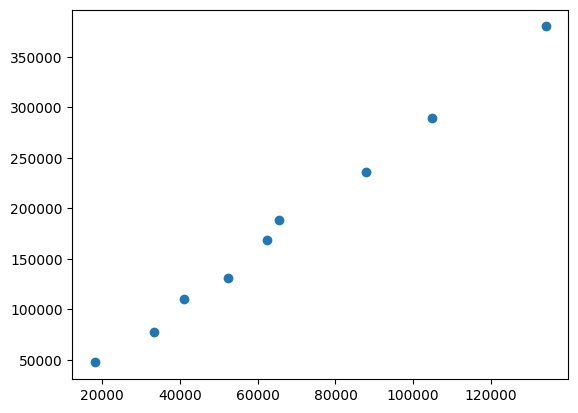

In [3]:
###Average value of 'Total Cost of Sales'against 'Gross Profit' for each account

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(df2['Total Cost of Sales'], df2['Gross Profit'], marker='o', linestyle='', label='Scatter Points')
plt.show()

<Axes: xlabel='Total Cost of Sales', ylabel='Gross Profit'>

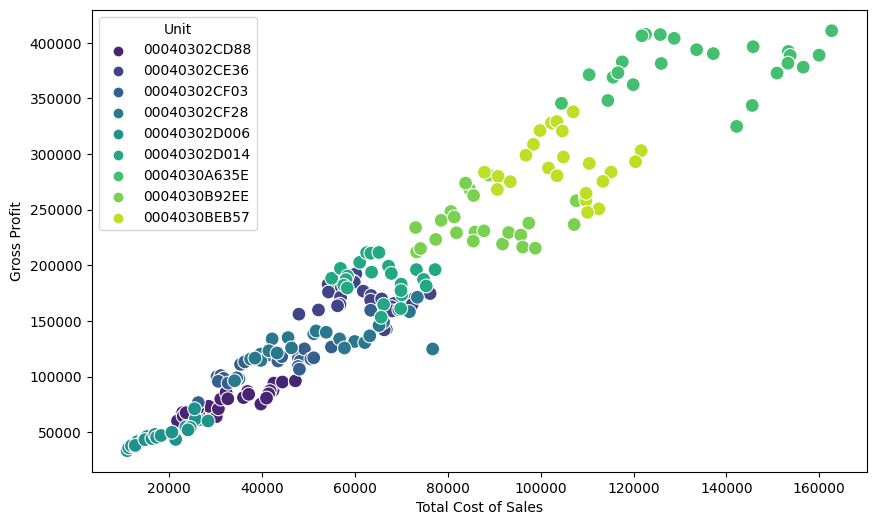

In [4]:
###'Total Cost of Sales' against 'Gross Profit' for each account for all the period
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Total Cost of Sales', y='Gross Profit', hue='Unit', palette='viridis', s=100)

In [5]:
np.polyfit(df2['Total Cost of Sales'], df2['Gross Profit'], 2)

array([ 1.38622432e-06,  2.68093882e+00, -5.41286057e+03])

#Comparison of effciency across all DMUs


In [6]:
###pip install pyDEA

In [7]:
###pip install deap

In [8]:
import pyDEA
import deap

In [9]:
import numpy as np
from deap import creator, base, tools, algorithms

# Define the fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create the toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Set up the evaluation function
def evaluate(individual):
    # DEA requires inputs and outputs. The output is Gross Profit, the input is Total Cost of Sales
    output = df2['Gross Profit'].to_numpy()
    input = df2['Total Cost of Sales'].to_numpy()

    # Calculate efficiency for each DMU
    efficiencies = output / (input * np.array(individual))
    return np.mean(efficiencies),

# Register the evaluation and selection methods
toolbox.register("evaluate", evaluate)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the genetic algorithm
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.0, mutpb=0.2, ngen=40,
                               stats=stats, halloffame=hof, verbose=True)

# Extract and print the most efficient individual
best_ind = hof[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




gen	nevals	avg   	std    	min   	max    
0  	100   	45.582	157.244	2.6697	1338.84
1  	12    	79.6877	133.909	-4.73971	530.737
2  	26    	181.692	178.708	-6.95432	530.737
3  	22    	328.602	167.95 	-9.09316	530.737
4  	26    	428.966	161.186	-12.3017	530.737
5  	18    	499.61 	104.88 	-5.62983	530.737
6  	21    	517.447	73.7575	2.40012 	530.737
7  	21    	513.934	95.7878	-84.5327	530.737
8  	13    	514.933	89.9356	-24.6756	530.737
9  	18    	492.851	138.239	-68.2418	530.737
10 	23    	497.225	157.457	-664.962	530.737
11 	22    	515.914	84.7525	-1.25994	530.737
12 	19    	514.777	90.7561	-4.45427	530.737
13 	24    	502.825	122.403	-147.388	530.737
14 	22    	514.543	92.1126	-27.6096	530.737
15 	16    	514.972	89.6558	-1.74649	530.737
16 	19    	520.077	74.6197	-2.72838	530.737
17 	21    	509.879	102.299	-10.7183	530.737
18 	18    	525.415	52.9544	-1.47398	530.737
19 	19    	525.386	53.2413	-4.35742	530.737
20 	18    	514.614	91.6862	-14.0522	530.737
21 	24    	514.836	90.4217	-6.7173 	53

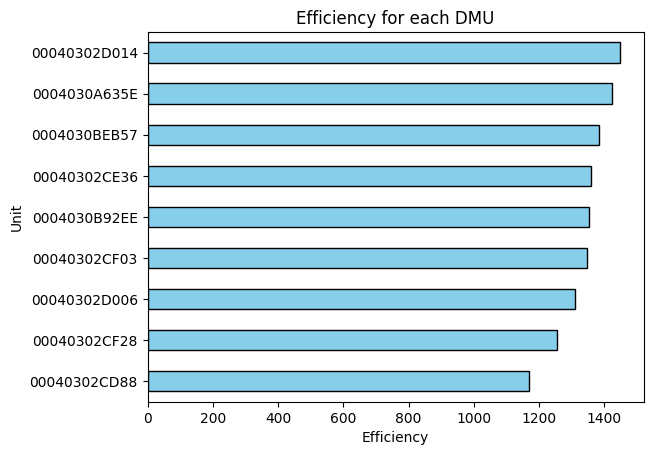

In [10]:
import matplotlib.pyplot as plt

# Calculate the efficiency for each DMU
df2['Efficiency'] = df2['Gross Profit'] / (df2['Total Cost of Sales'] * np.array(best_ind))

# Sort DataFrame by 'Efficiency' column from high to low
df2 = df2.sort_values(by='Efficiency', ascending=False)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot efficiencies
df2['Efficiency'].plot(kind='barh', ax=ax, color='skyblue', edgecolor='k')

# Invert y-axis to have units in descending order
ax.invert_yaxis()

# Set labels and title
ax.set_xlabel('Efficiency')
ax.set_ylabel('Unit')
ax.set_title('Efficiency for each DMU')

# Show the plot
plt.show()
